## Using the simulation model as a decision support system (DSS)

### In the following experiment, we compare three different resource configurations in 12 replications 

### The resource configurations are as follows:
1. Current: current configuration of fire services in Tehran
2. Nominal: Solution of a maximum coverage optimization model with expected demand values. (The solution was computed with the relaxation of only 15 stations)
3. MiniGap: Solution of an optimization model which tries to minimize the gap between different demand scenarios. (The solution was computed with the relaxation of only 15 stations)
---------------------------------------------------
### We try to consider uncertainties in replications. Each configuration runs 12 replications: 
1. Four different demand scenarios: We address the random nature of incident occurrence by considering different demand scenarios. 
2. Three different OD matrixes: We consider different network states by running the simulation model in AM-Peak, Pm-Peak, and Off-Peak.

In [3]:
import simpy
import numpy as np 
import pandas as pd 
from collections import namedtuple
import time
import geopandas as gpd
import matplotlib.pyplot as plt

In [9]:
from src.zone import Zone 
from src.station import Station
from src.network import Network

from src.call_arrival import call_arrival
from src.incident_process import incident_process

from src.helper_functions_outputs import process_data
from src.helper_functions_outputs import box_plots
from src.helper_functions_outputs import plot_zonal_results

### Loading the inputs

#### 1. OD Matrix

In [10]:
ods = []
for i in [1,2,3,4]:
    d = pd.read_csv(f'data/OD_Matrix/od_{i}.csv',dtype={'zone': np.str_})
    d = d.set_index('zone')
    d = d.replace(0,120)
    ods.append(d)

#### 2. Resource Configurations

In [12]:
locs = []
for i in [1,2,3]:
    lc = pd.read_csv(f'data/Resource_Configurations/config_{i}.csv',dtype={'zone': np.str_})
    lc = lc.set_index('zone')
    locs.append(lc)

#### 4. Incident's Realizations

In [13]:
incidents = []
for i in [1,2,3,4,5]:
    inci = pd.read_csv(f'/mnt/e/Python/Github/emergency/data/Arrivals/arrival_{i}.csv', index_col='num')
    incidents.append(inci)

#### 5. Geographical Data of study area

In [26]:
zone = gpd.read_file('data/study area/zones_studyarea.shp')

## Assumptions

In [20]:
## 1. Incidetns types and their required vehicles 
incident_type = {1:{'t1':1, 't2':1},
                 2:{'t1':1, 't2':2},
                 3:{'t1':1, 't2':2, 't3':1}}

# 2. Standard travel time for different vehicles (seconds)
time_st_t1 = 9*60
time_st_t2 = 9*60
time_st_t3 = 14*60

# Number of zones (node) in the network 
zone_num = 693

configuration_name = ['Current', 'Nominal', 'MiniGap']

### Running the Experiment 

In [17]:
result = {0:[],
           1:[],
           2:[]}

start = time.time()

for z in [0,1,2]:
    loc = locs[z]
    for j in [0,1,3]:
        od = ods[j]
        for i in [0,1,2,3]:
            incident = incidents[i]
            env = simpy.Environment()
            network = Network( od, loc, zone_num, time_st_t1, time_st_t2, time_st_t3, len(incident), incident,env)
            network.generate_station()
            network.generate_zone()
            network.generate_zone_nearest()
            env.process(incident_process(env, incident, network,incident_type))
            env.run()
            network.generate_result()
            network.compute_util()
            network.generate_station_db()
            network.generate_zonal_db()

            result[z].append(network)
        
end = time.time()

print(end-start)

1660.5804030895233


### Performance parameters

#### 1. Utilization 

In [21]:
fields = ['t1_util','t2_util','t3_util']
param = 'utilization'
utilization_data = process_data(result, fields, param)

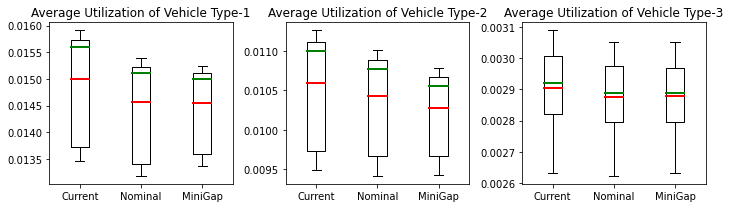

In [22]:
box_plots(data=utilization_data, param='utilization', configuration_name=configuration_name)

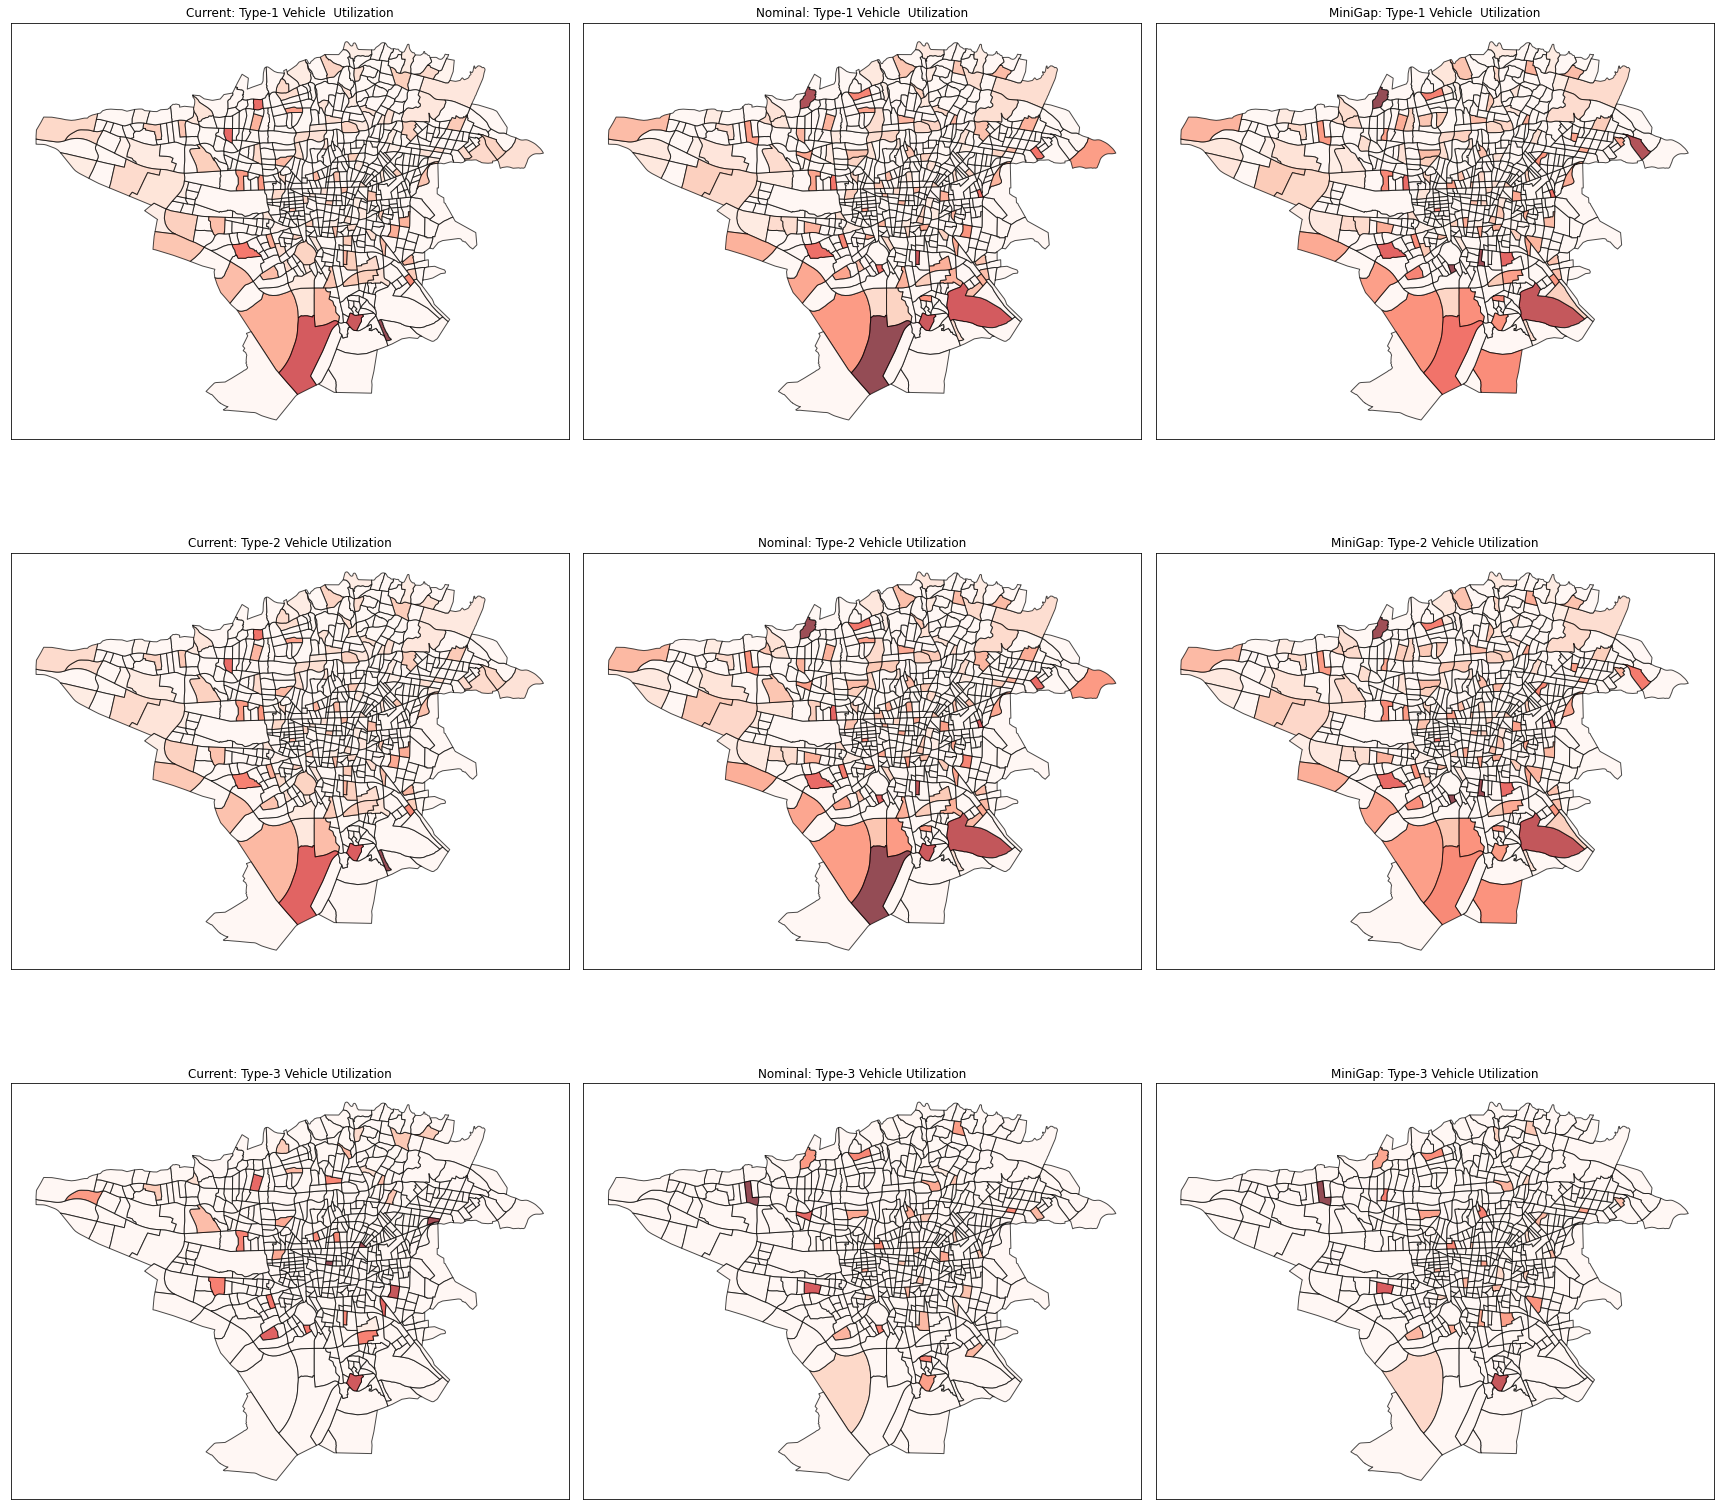

In [27]:
plot_zonal_results(data=utilization_data, param='Utilization', configuration_name=configuration_name, zone=zone)

#### 2. Coverage  

In [28]:
fields= ['cov_e1', 'cov_e2', 'cov_e3']
param = 'coverage'
coverage_data = process_data(result, fields, param)

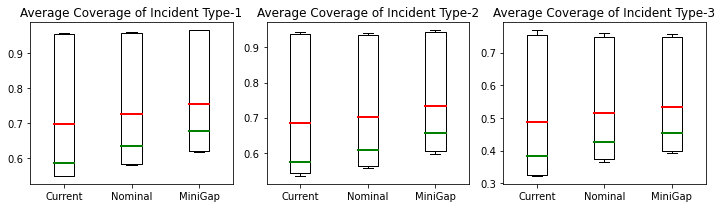

In [29]:
box_plots(data=coverage_data, param='coverage', configuration_name=configuration_name)

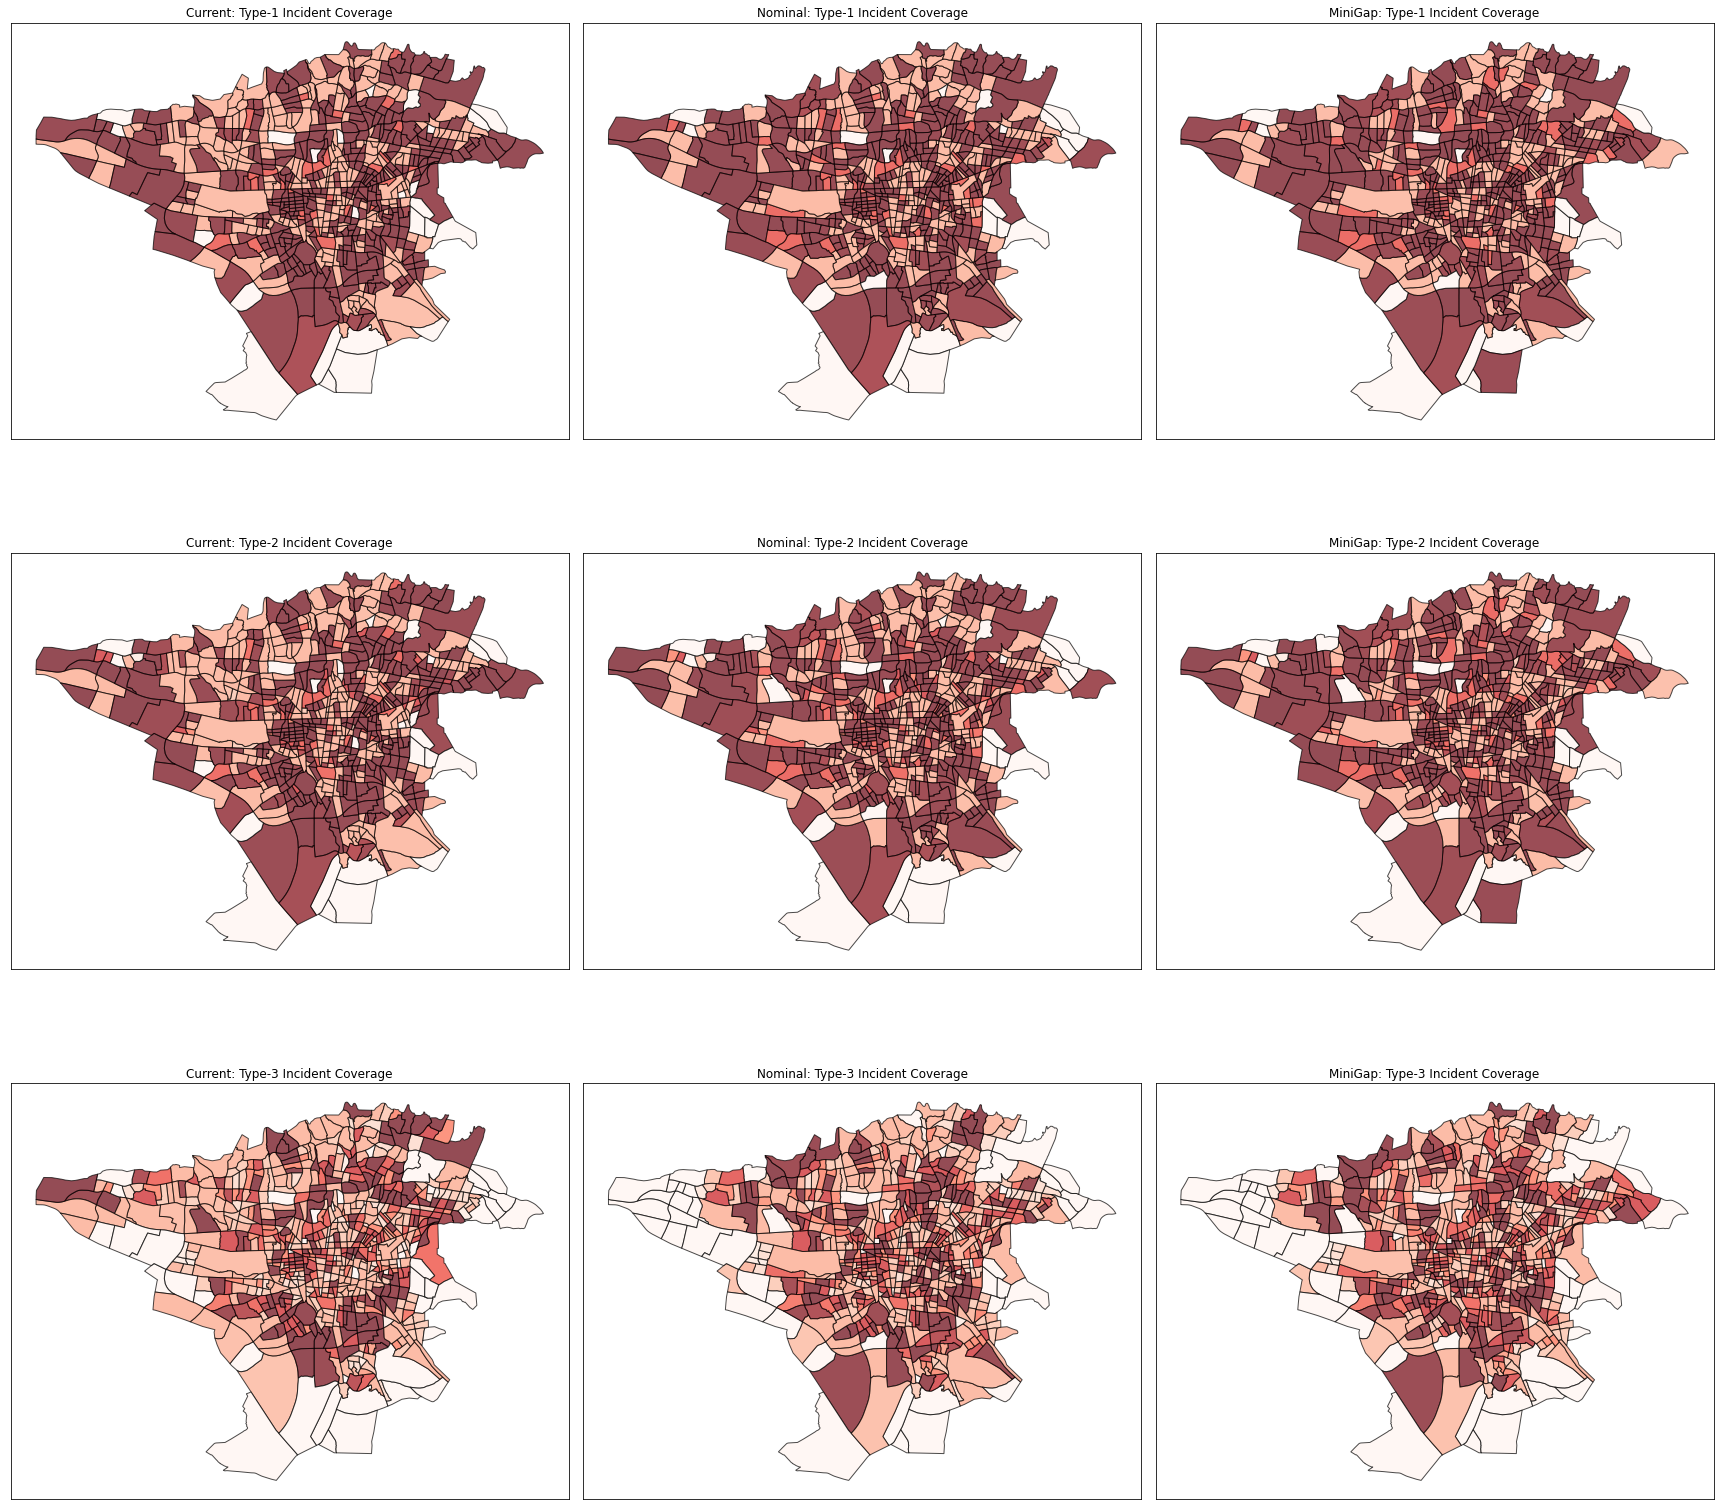

In [30]:
plot_zonal_results(data=coverage_data, param='Coverage', configuration_name=configuration_name, zone=zone)

#### 3. (Traversal) Number of traversed Station before finding first available vehicle 

In [31]:
fields = ['e1_trvs', 'e2_trvs', 'e3_trvs']
param = 'traversal'
traversal_data = process_data(result, fields, param)

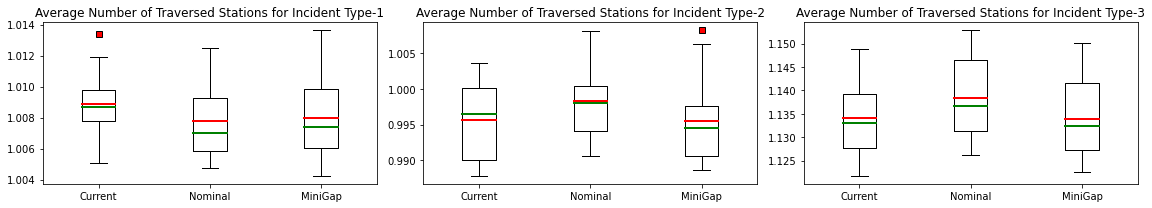

In [32]:
box_plots(data=traversal_data, param='traversal', configuration_name=configuration_name)

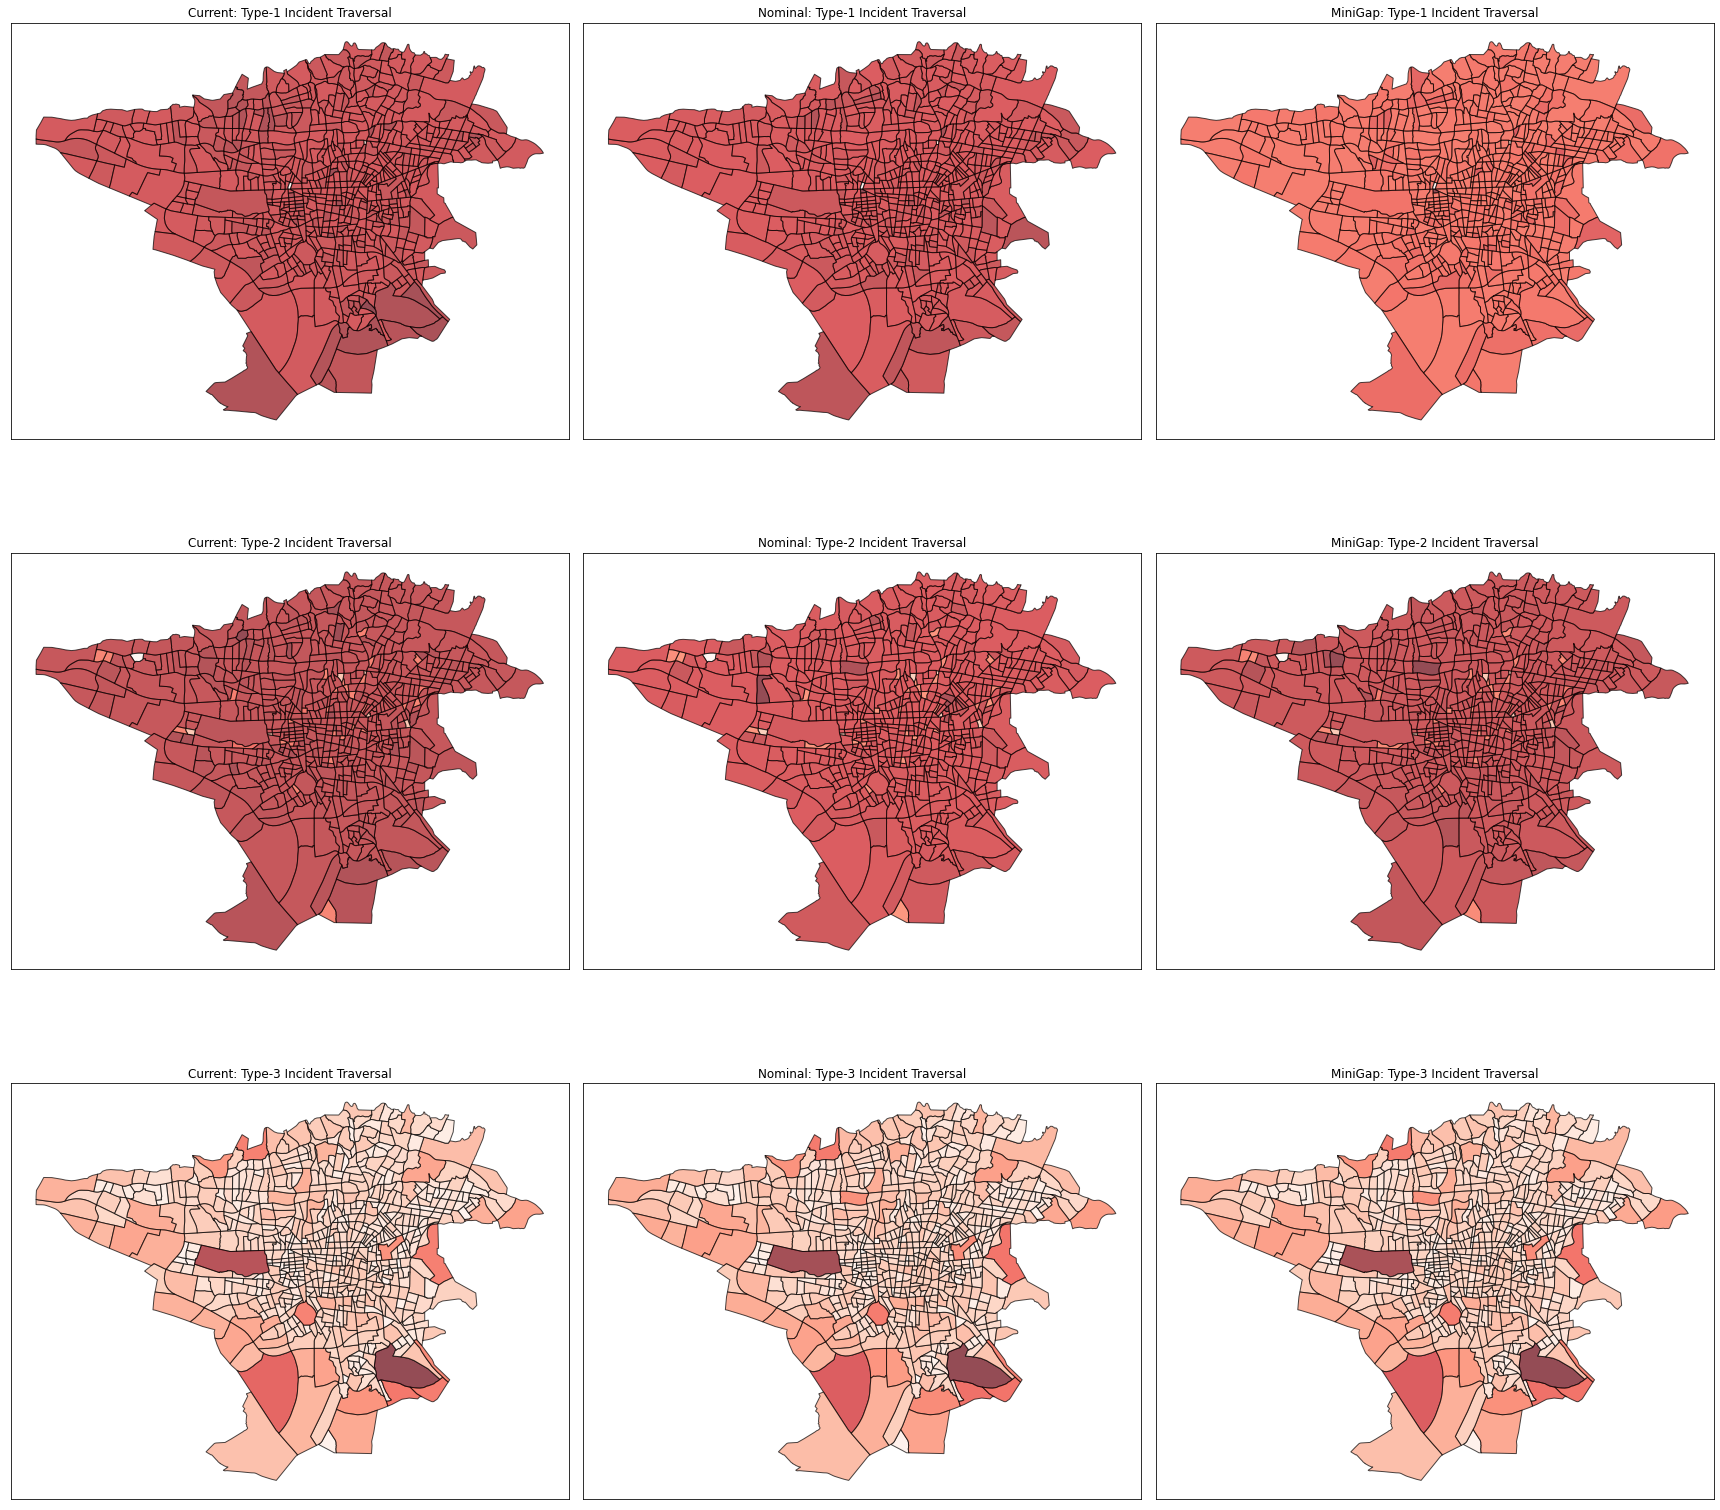

In [33]:
plot_zonal_results(data=traversal_data, param='Traversal', configuration_name=configuration_name, zone=zone)

#### 4. All units' average travel time 

In [34]:
fields = ['tt_e1', 'tt_e2', 'tt_e3']
param='travel_time_incident'
travel_time_incident_data = process_data(result, fields, param)

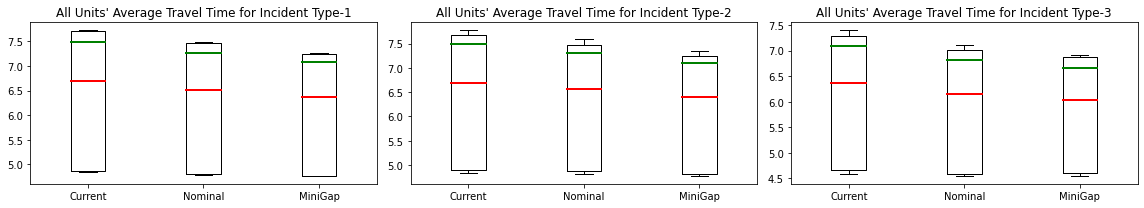

In [35]:
box_plots(data=travel_time_incident_data, param='travel_time_incident', configuration_name=configuration_name)

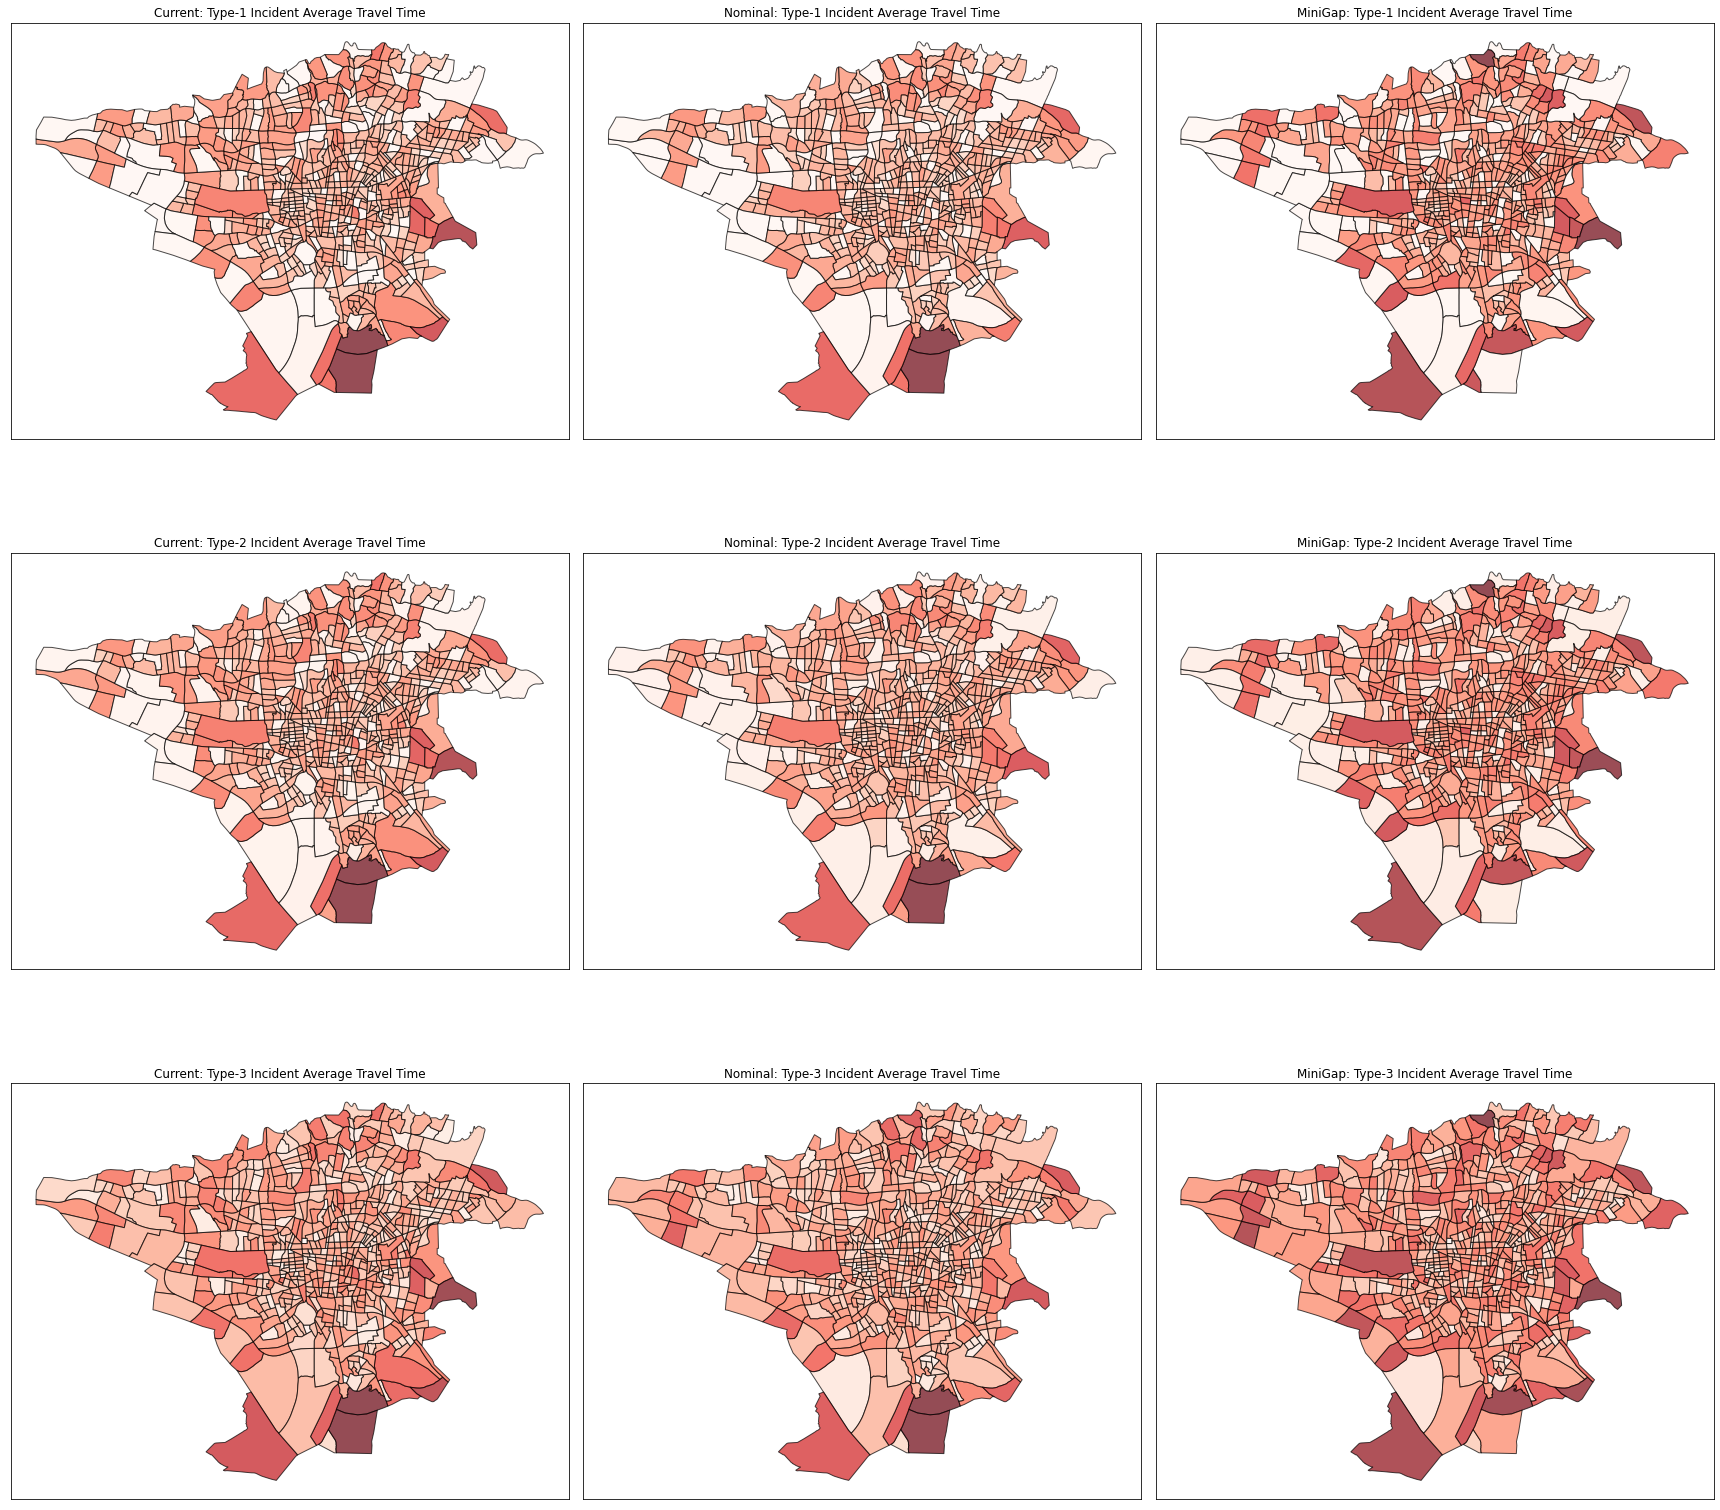

In [36]:
plot_zonal_results(data=travel_time_incident_data, param='Travel Time', configuration_name=configuration_name, zone=zone)